In [3]:
# Import required PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, when

# Create Spark session
spark = SparkSession.builder \
    .appName("Employee Attrition Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Define the schema for our dataset
schema = StructType([
    StructField("Employee_ID", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Gender", StringType(), True),
    StructField("Years_at_Company", IntegerType(), True),
    StructField("Job_Role", StringType(), True),
    StructField("Monthly_Income", DoubleType(), True),
    StructField("Work_Life_Balance", StringType(), True),
    StructField("Job_Satisfaction", StringType(), True),
    StructField("Performance_Rating", StringType(), True),
    StructField("Number_of_Promotions", IntegerType(), True),
    StructField("Overtime", StringType(), True),
    StructField("Distance_from_Home", DoubleType(), True),
    StructField("Education_Level", StringType(), True),
    StructField("Marital_Status", StringType(), True),
    StructField("Number_of_Dependents", IntegerType(), True),
    StructField("Job_Level", StringType(), True),
    StructField("Company_Size", StringType(), True),
    StructField("Company_Tenure", DoubleType(), True),
    StructField("Remote_Work", StringType(), True),
    StructField("Leadership_Opportunities", StringType(), True),
    StructField("Innovation_Opportunities", StringType(), True),
    StructField("Company_Reputation", StringType(), True),
    StructField("Employee_Recognition", StringType(), True),
    StructField("Attrition", StringType(), True)
])

# Read the CSV file with the defined schema
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .schema(schema) \
    .load("/content/train.csv")

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

# Display schema
print("\nDataset Schema:")
df.printSchema()

# Show first few rows
print("\nSample Data:")
df.show(5)

# Display summary statistics for numeric columns
print("\nSummary Statistics for Numeric Columns:")
df.select([col for col in df.columns if df.schema[col].dataType in [IntegerType(), DoubleType()]]) \
  .describe().show()

# Display unique values in categorical columns
categorical_columns = ["Gender", "Job_Role", "Work_Life_Balance", "Job_Satisfaction",
                      "Performance_Rating", "Education_Level", "Marital_Status",
                      "Job_Level", "Company_Size", "Remote_Work", "Leadership_Opportunities",
                      "Innovation_Opportunities", "Company_Reputation", "Employee_Recognition",
                      "Attrition"]

print("\nUnique values in categorical columns:")
for col_name in categorical_columns:
    print(f"\n{col_name}:")
    df.select(col_name).distinct().show()

Dataset Overview:
Number of rows: 59598
Number of columns: 24

Dataset Schema:
root
 |-- Employee_ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Years_at_Company: integer (nullable = true)
 |-- Job_Role: string (nullable = true)
 |-- Monthly_Income: double (nullable = true)
 |-- Work_Life_Balance: string (nullable = true)
 |-- Job_Satisfaction: string (nullable = true)
 |-- Performance_Rating: string (nullable = true)
 |-- Number_of_Promotions: integer (nullable = true)
 |-- Overtime: string (nullable = true)
 |-- Distance_from_Home: double (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Number_of_Dependents: integer (nullable = true)
 |-- Job_Level: string (nullable = true)
 |-- Company_Size: string (nullable = true)
 |-- Company_Tenure: double (nullable = true)
 |-- Remote_Work: string (nullable = true)
 |-- Leadership_Opportunities: string (nullable = true

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, when, count, isnan, isnull, mean
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as F

# List of categorical and numerical columns
categorical_columns = [
    "Gender", "Job_Role", "Work_Life_Balance", "Job_Satisfaction",
    "Performance_Rating", "Overtime", "Education_Level", "Marital_Status",
    "Job_Level", "Company_Size", "Remote_Work", "Leadership_Opportunities",
    "Innovation_Opportunities", "Company_Reputation", "Employee_Recognition"
]

numerical_columns = [
    "Age", "Years_at_Company", "Monthly_Income", "Number_of_Promotions",
    "Distance_from_Home", "Number_of_Dependents", "Company_Tenure"
]

# 1. Handle Missing Values
def handle_missing_values(df):
    # Check for missing values
    print("Missing Values Count:")
    for column in df.columns:
        missing_count = df.filter(
            col(column).isNull() |
            isnan(col(column)) |
            (col(column) == '')
        ).count()
        print(f"{column}: {missing_count}")

    # Handle missing numerical values with mean imputation
    for column in numerical_columns:
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.na.fill({column: mean_value})

    # Handle missing categorical values with mode imputation
    for column in categorical_columns:
        mode_value = df.groupBy(column).count().orderBy('count', ascending=False).first()[0]
        df = df.na.fill({column: mode_value})

    return df

# 2. Create StringIndexers for categorical variables
indexers = [
    StringIndexer(inputCol=column, outputCol=f"{column}_indexed", handleInvalid="keep")
    for column in categorical_columns
]

# 3. Create OneHotEncoders for indexed variables
encoders = [
    OneHotEncoder(
        inputCol=f"{column}_indexed",
        outputCol=f"{column}_encoded"
    )
    for column in categorical_columns
]

# 4. Create VectorAssembler for numerical columns
numeric_assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol="numerical_features"
)

# 5. Create StandardScaler for numerical features
scaler = StandardScaler(
    inputCol="numerical_features",
    outputCol="scaled_numerical_features",
    withStd=True,
    withMean=True
)

# 6. Create VectorAssembler for final feature vector
encoded_columns = [f"{column}_encoded" for column in categorical_columns]
final_assembler = VectorAssembler(
    inputCols=["scaled_numerical_features"] + encoded_columns,
    outputCol="features"
)

# 7. Create StringIndexer for target variable (Attrition)
label_indexer = StringIndexer(inputCol="Attrition", outputCol="label")

# Create and apply the pipeline
pipeline = Pipeline(stages=[
    *indexers,
    *encoders,
    numeric_assembler,
    scaler,
    final_assembler,
    label_indexer
])

# Apply preprocessing steps
df_processed = handle_missing_values(df)

# Fit and transform the pipeline
pipeline_model = pipeline.fit(df_processed)
final_df = pipeline_model.transform(df_processed)

# Select relevant columns for modeling
modeling_df = final_df.select("features", "label")

# Display sample of processed data
print("\nProcessed Data Sample:")
modeling_df.show(5, truncate=False)

# Get feature vector size
feature_vector_size = modeling_df.select("features").first()[0].size
print(f"\nFeature Vector Size: {feature_vector_size}")

# Calculate class distribution
print("\nClass Distribution:")
final_df.groupBy("Attrition").count().show()

# Save processed data for later use
modeling_df.cache()

Missing Values Count:
Employee_ID: 0
Age: 0
Gender: 0
Years_at_Company: 0
Job_Role: 0
Monthly_Income: 0
Work_Life_Balance: 0
Job_Satisfaction: 0
Performance_Rating: 0
Number_of_Promotions: 0
Overtime: 0
Distance_from_Home: 0
Education_Level: 0
Marital_Status: 0
Number_of_Dependents: 0
Job_Level: 0
Company_Size: 0
Company_Tenure: 0
Remote_Work: 0
Leadership_Opportunities: 0
Innovation_Opportunities: 0
Company_Reputation: 0
Employee_Recognition: 0
Attrition: 0

Processed Data Sample:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                    

DataFrame[features: vector, label: double]

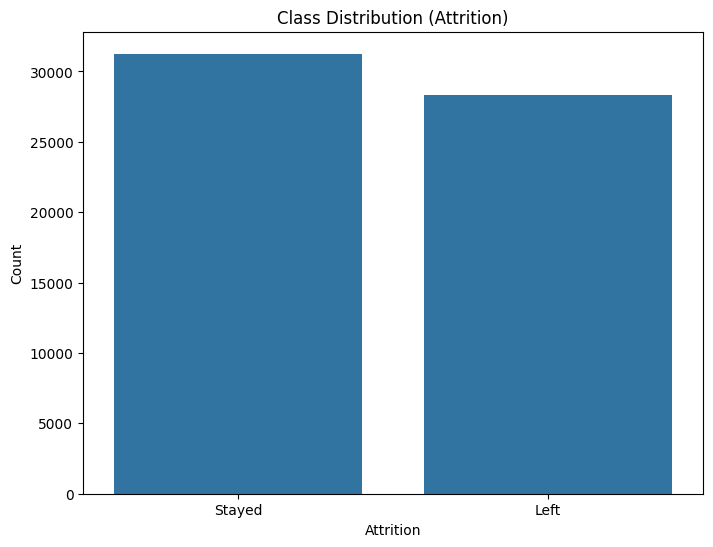


Class Distribution:
Attrition
Stayed    0.524514
Left      0.475486
Name: proportion, dtype: float64


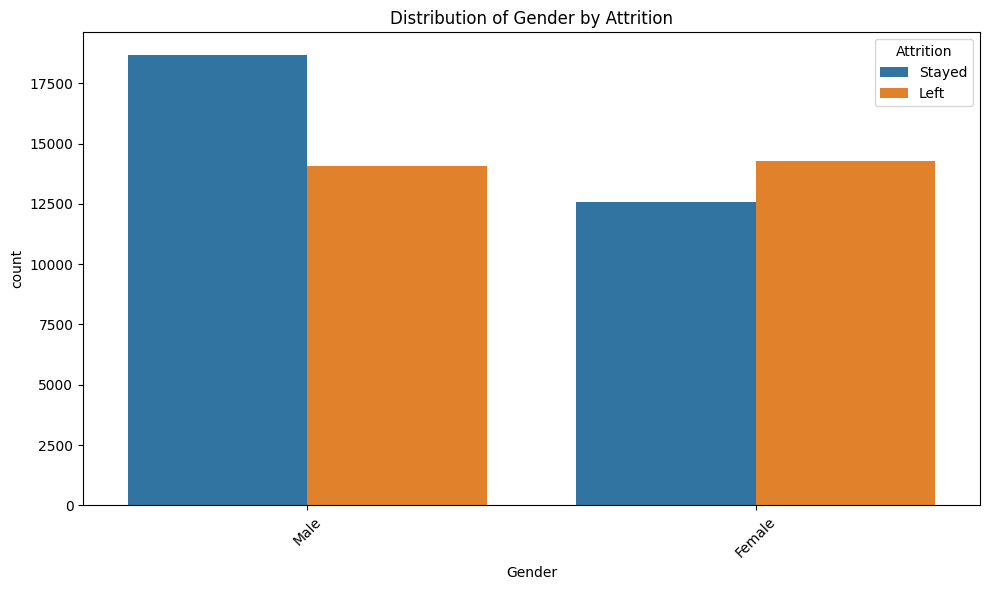

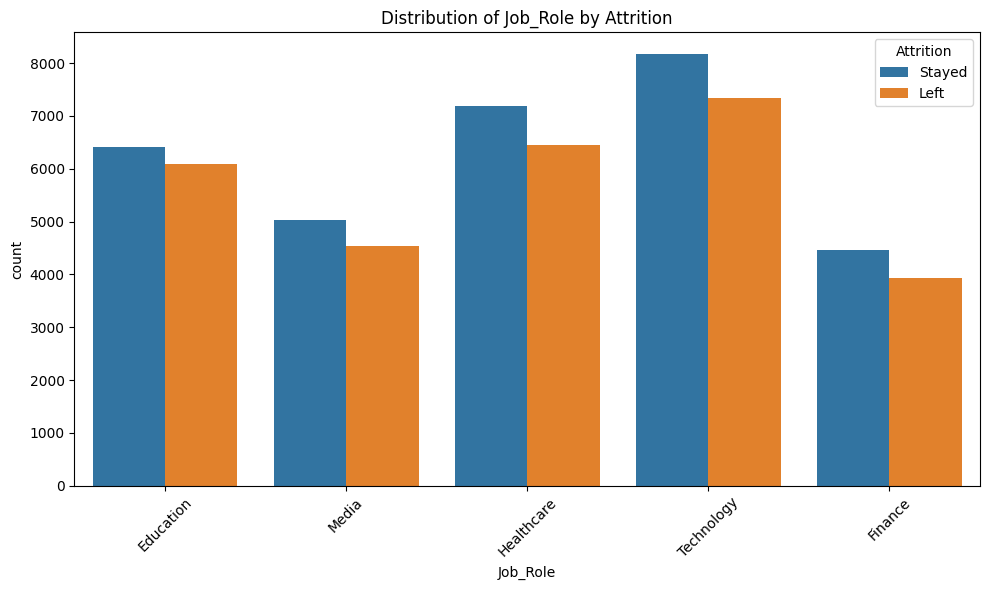

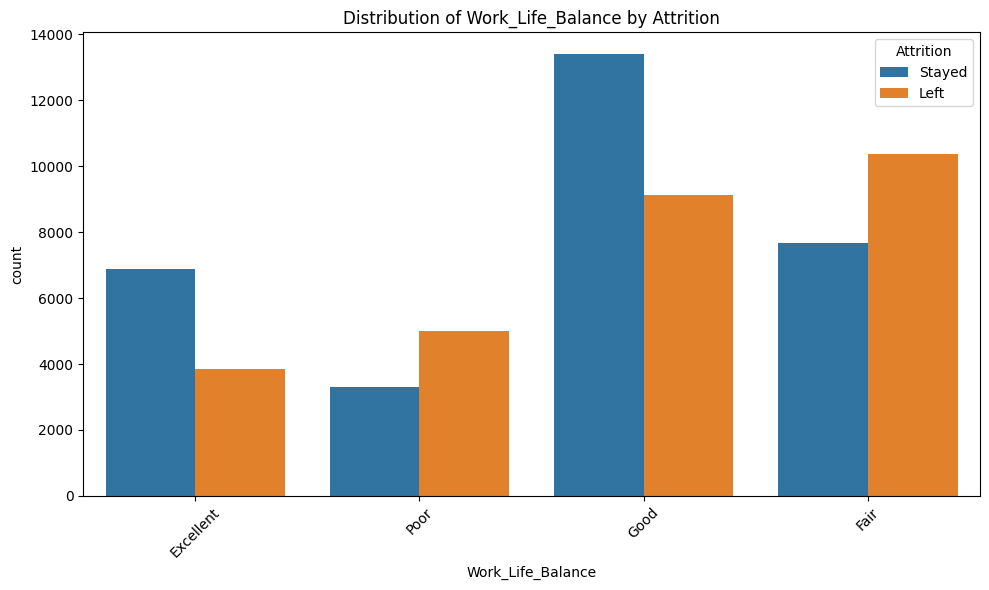

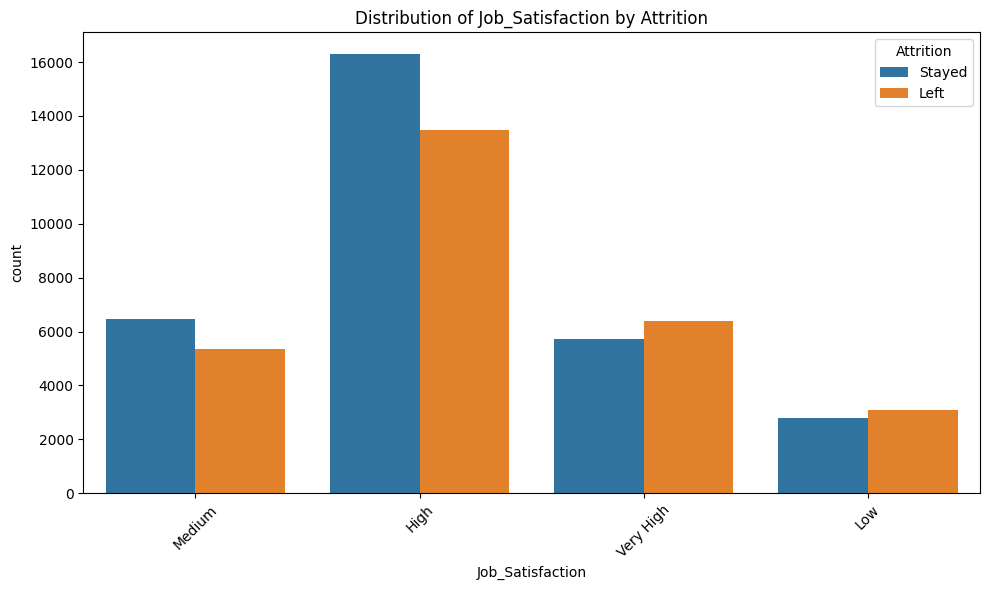

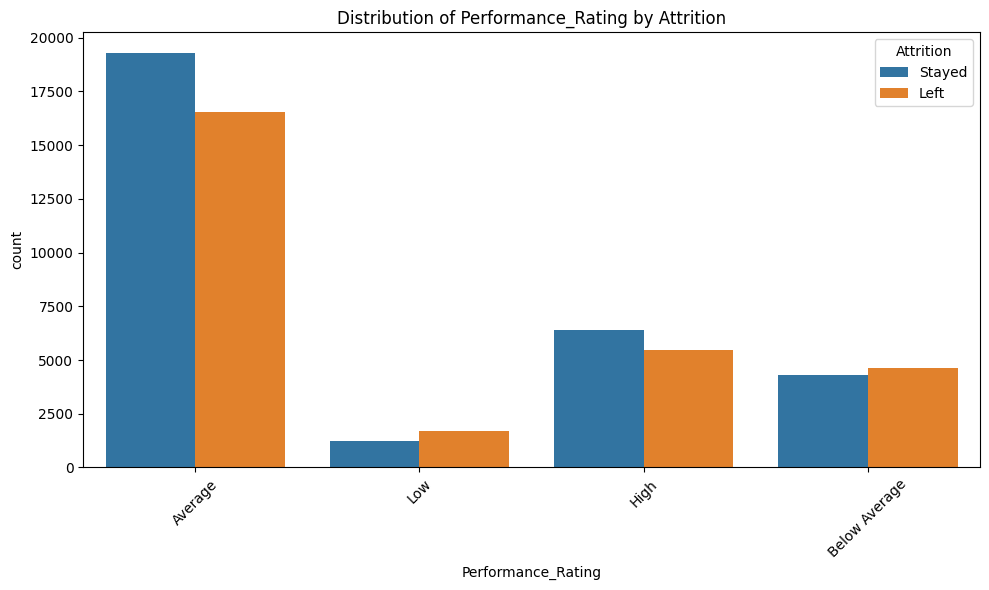

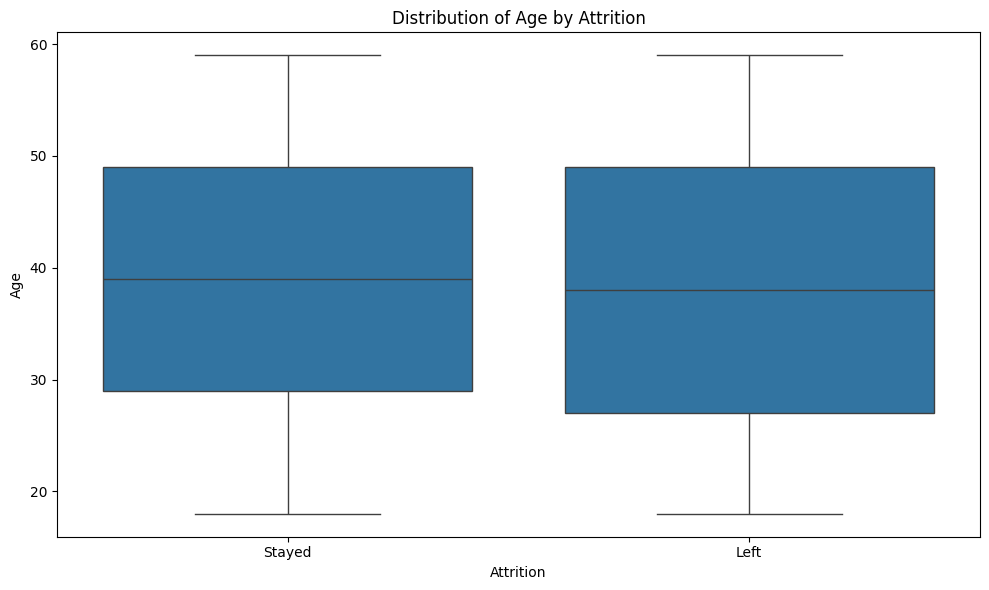

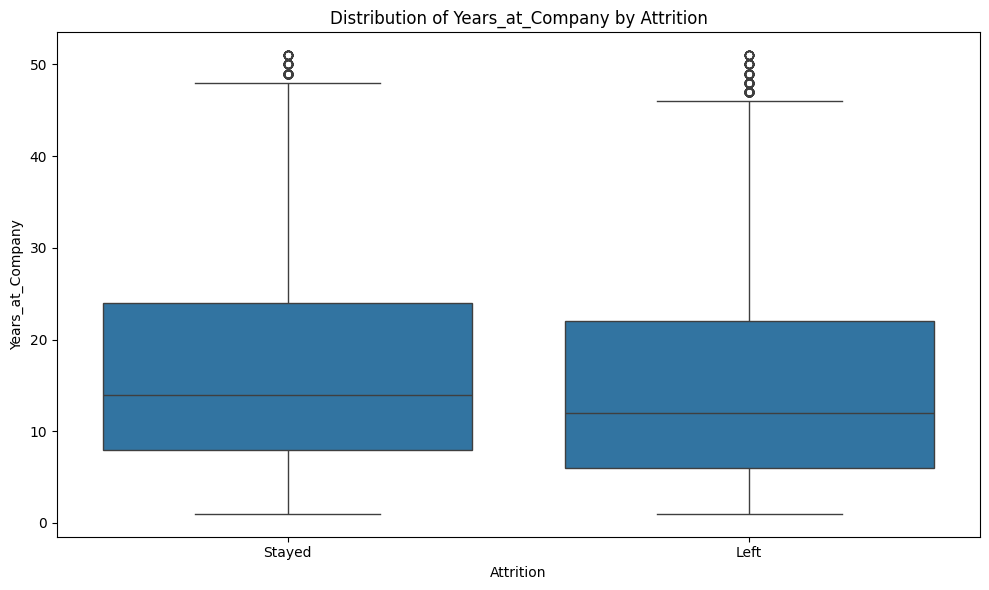

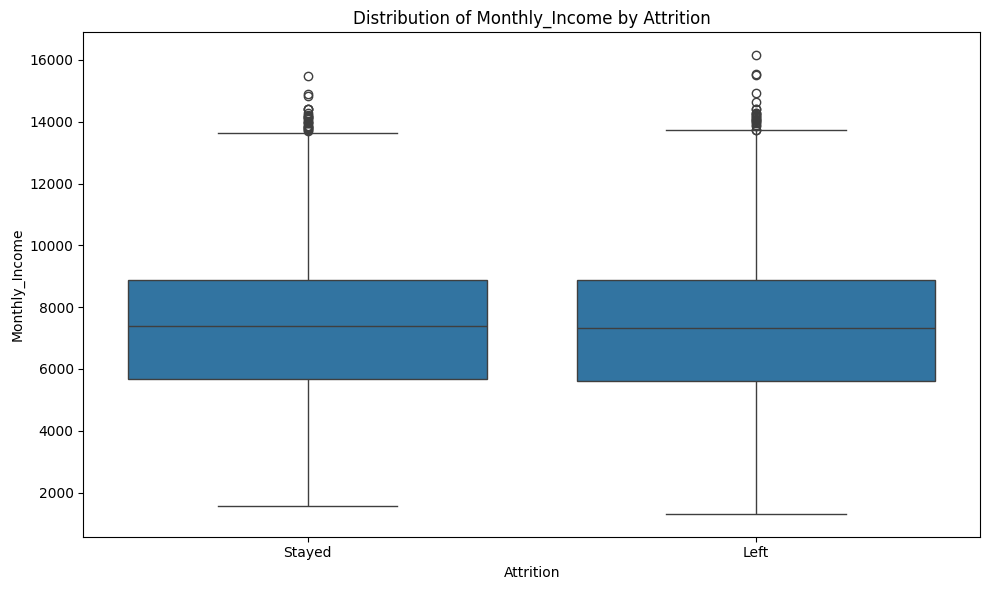

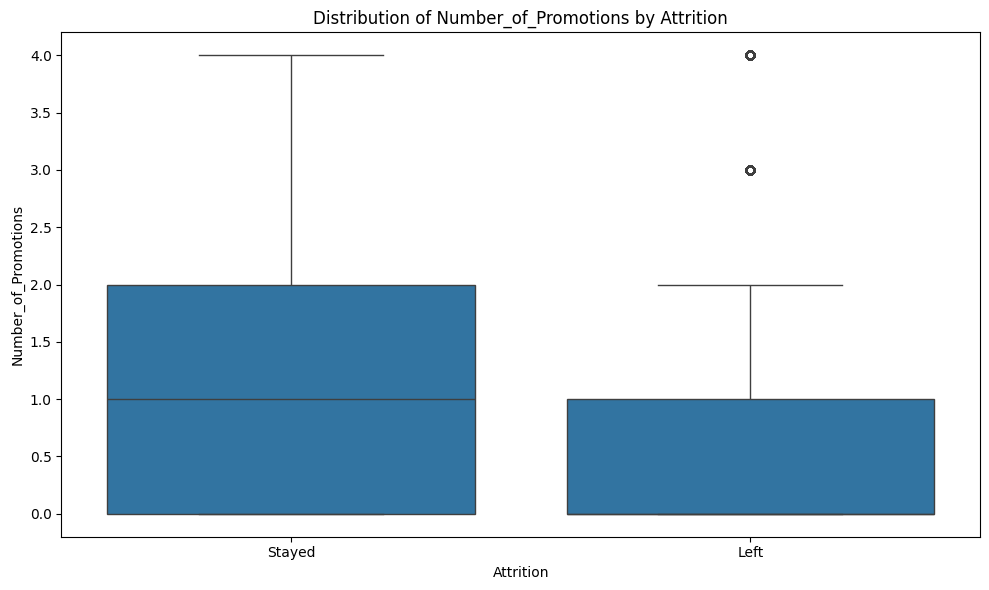

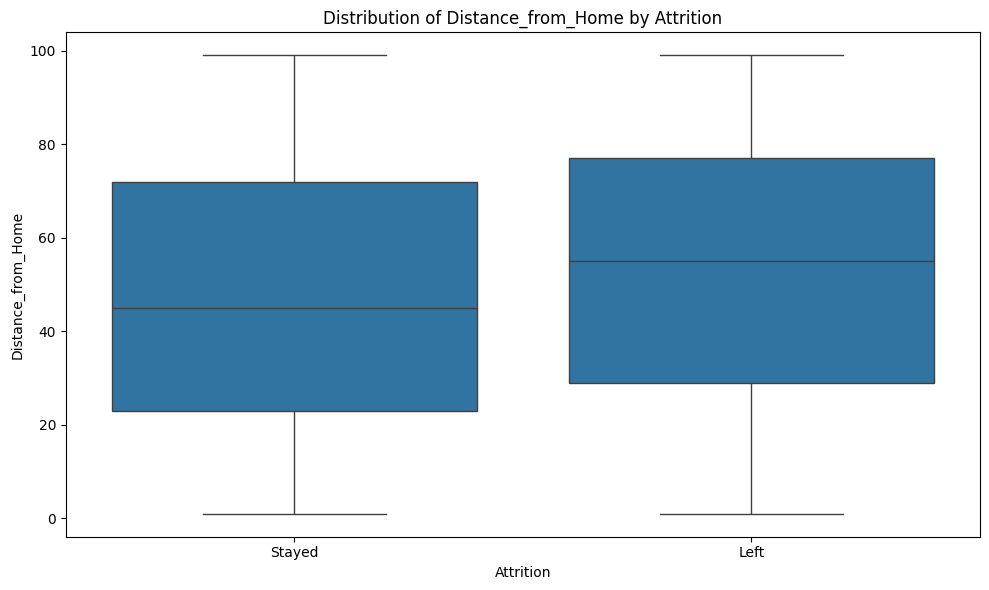

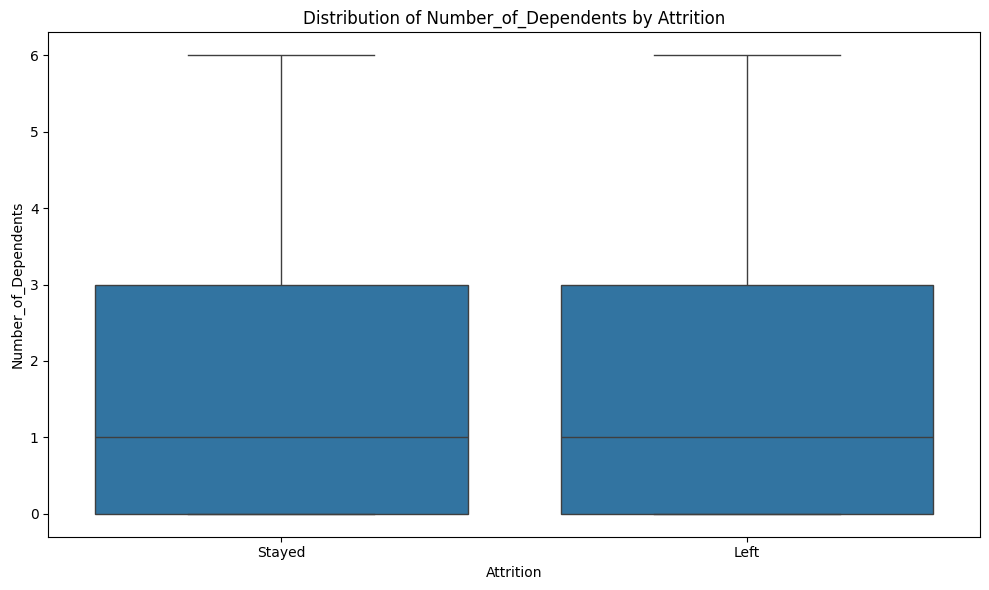

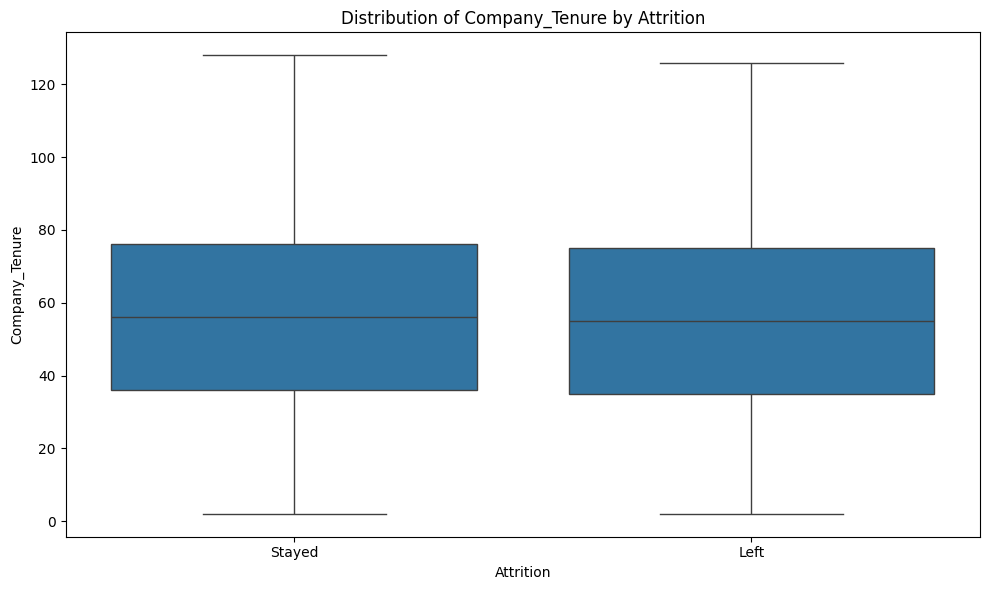

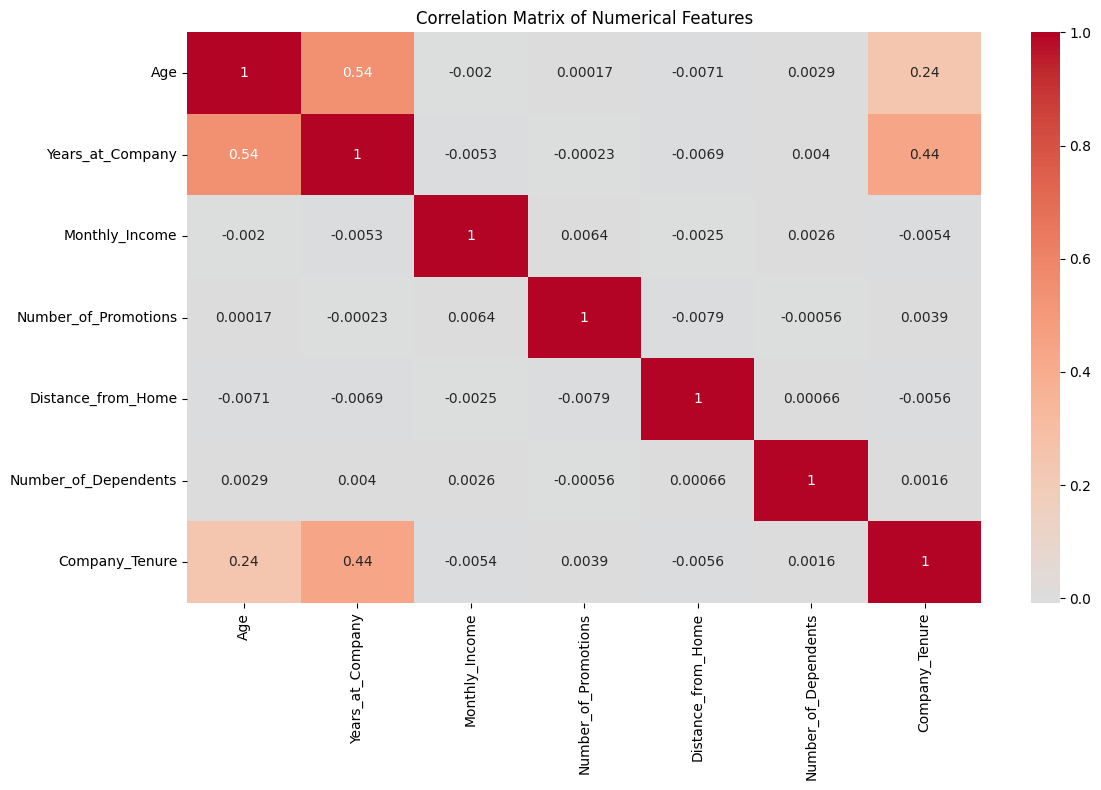

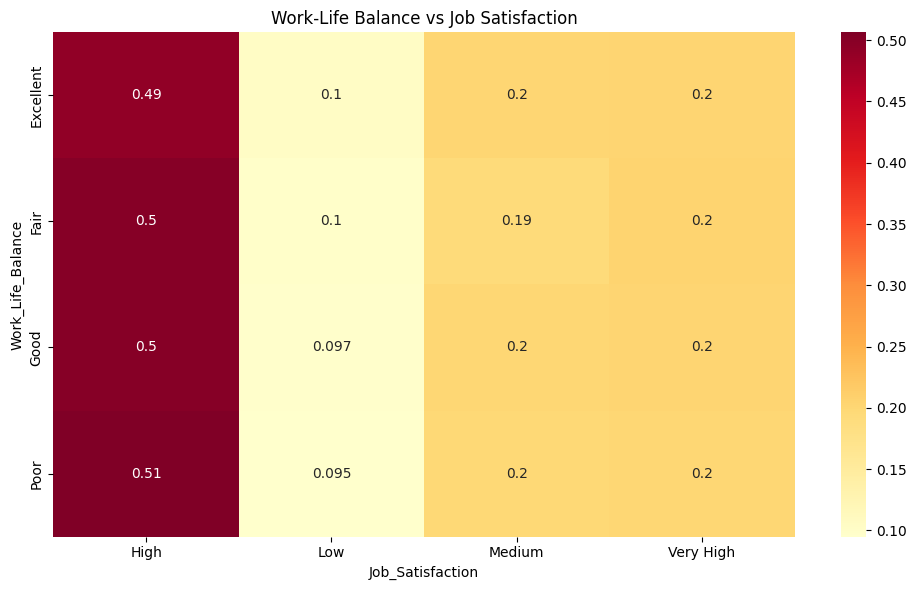

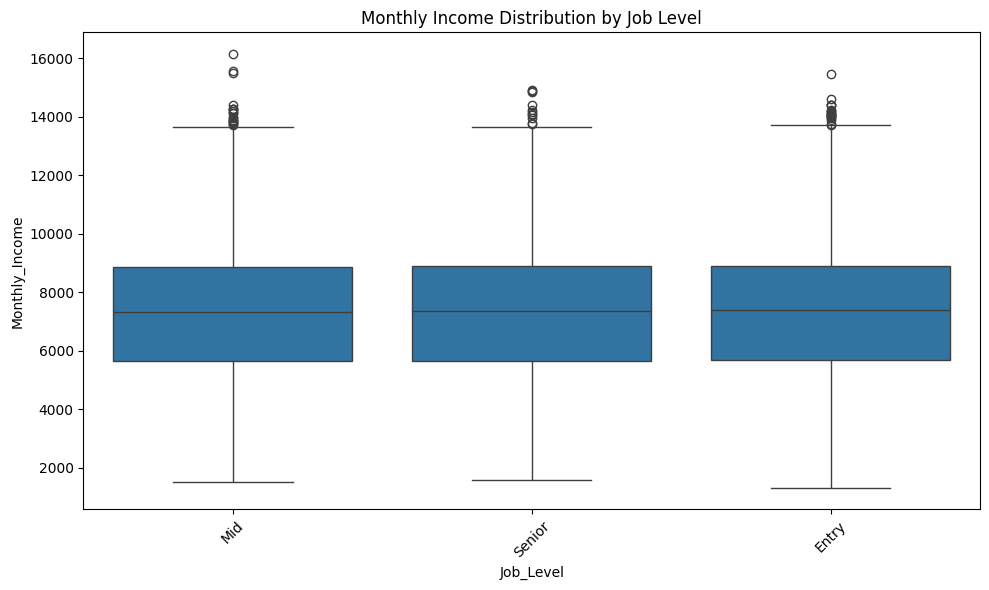


Summary Statistics for Numerical Features:
                Age  Years_at_Company  Monthly_Income  Number_of_Promotions  \
count  59598.000000      59598.000000    59598.000000          59598.000000   
mean      38.565875         15.753901     7302.397983              0.832578   
std       12.079673         11.245981     2151.457423              0.994991   
min       18.000000          1.000000     1316.000000              0.000000   
25%       28.000000          7.000000     5658.000000              0.000000   
50%       39.000000         13.000000     7354.000000              1.000000   
75%       49.000000         23.000000     8880.000000              2.000000   
max       59.000000         51.000000    16149.000000              4.000000   

       Distance_from_Home  Number_of_Dependents  Company_Tenure  
count        59598.000000          59598.000000    59598.000000  
mean            50.007651              1.648075       55.758415  
std             28.466459              1.55568

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



# Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()




# Create a function for plotting countplots
def plot_categorical_distribution(data, column, target='Attrition'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, hue=target)
    plt.title(f'Distribution of {column} by {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create a function for plotting boxplots
def plot_numerical_distribution(data, column, target='Attrition'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=target, y=column)
    plt.title(f'Distribution of {column} by {target}')
    plt.tight_layout()
    plt.show()

# 1. Class Balance Check
plt.figure(figsize=(8, 6))
class_balance = pandas_df['Attrition'].value_counts()
sns.barplot(x=class_balance.index, y=class_balance.values)
plt.title('Class Distribution (Attrition)')
plt.ylabel('Count')
plt.show()
print("\nClass Distribution:")
print(pandas_df['Attrition'].value_counts(normalize=True))

# 2. Categorical Features Analysis
categorical_features = [
    'Gender', 'Job_Role', 'Work_Life_Balance', 'Job_Satisfaction',
    'Performance_Rating', 'Overtime', 'Education_Level', 'Marital_Status',
    'Job_Level', 'Company_Size', 'Remote_Work', 'Leadership_Opportunities',
    'Innovation_Opportunities', 'Company_Reputation', 'Employee_Recognition'
]

# Plot distribution for categorical variables
for feature in categorical_features[:5]:  # Showing first 5 for brevity
    plot_categorical_distribution(pandas_df, feature)

# 3. Numerical Features Analysis
numerical_features = [
    'Age', 'Years_at_Company', 'Monthly_Income', 'Number_of_Promotions',
    'Distance_from_Home', 'Number_of_Dependents', 'Company_Tenure'
]

# Plot distribution for numerical variables
for feature in numerical_features:
    plot_numerical_distribution(pandas_df, feature)

# 4. Correlation Analysis for Numerical Features
plt.figure(figsize=(12, 8))
correlation_matrix = pandas_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# 5. Key Insights Analysis
# Work-Life Balance vs Job Satisfaction
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(pandas_df['Work_Life_Balance'],
                        pandas_df['Job_Satisfaction'],
                        normalize='index'),
            annot=True, cmap='YlOrRd')
plt.title('Work-Life Balance vs Job Satisfaction')
plt.tight_layout()
plt.show()

# Monthly Income Distribution by Job Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Job_Level', y='Monthly_Income', data=pandas_df)
plt.title('Monthly Income Distribution by Job Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate summary statistics
summary_stats = pandas_df[numerical_features].describe()
print("\nSummary Statistics for Numerical Features:")
print(summary_stats)

# Calculate chi-square test for categorical variables vs Attrition
print("\nChi-square test results for categorical variables vs Attrition:")
for feature in categorical_features:
    contingency_table = pd.crosstab(pandas_df[feature], pandas_df['Attrition'])
    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    print(f"{feature}: chi2 = {chi2:.2f}, p-value = {p_value:.4f}")

# Feature importance based on correlation with Attrition
# Convert Attrition to numeric (0/1) for correlation analysis
pandas_df['Attrition_Numeric'] = (pandas_df['Attrition'] == 'left').astype(int)
correlation_with_attrition = pandas_df[numerical_features + ['Attrition_Numeric']].corr()['Attrition_Numeric'].sort_values(ascending=False)
print("\nCorrelation with Attrition:")
print(correlation_with_attrition)


Training Logistic Regression (PySpark)...

Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      6235
         1.0       0.74      0.73      0.74      5649

    accuracy                           0.75     11884
   macro avg       0.75      0.75      0.75     11884
weighted avg       0.75      0.75      0.75     11884


Confusion Matrix:


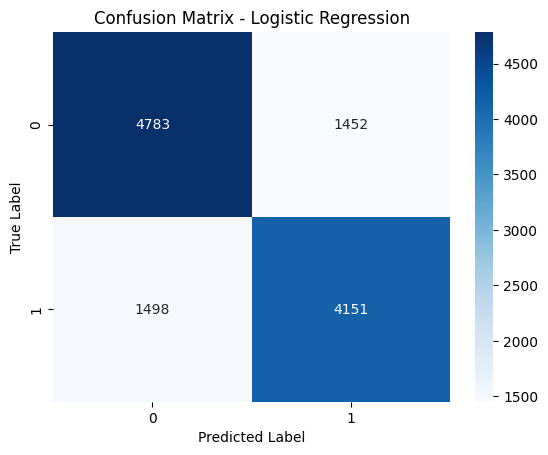


ROC-AUC Score: 0.8425

Logistic Regression Feature Importance:
Feature 0: -0.0669
Feature 1: -0.1468
Feature 2: -0.0118
Feature 3: -0.2516
Feature 4: 0.2861
Feature 5: -0.2343
Feature 6: -0.0075
Feature 7: -0.3163
Feature 8: 0.3163
Feature 9: -0.0199
Feature 10: -0.0061
Feature 11: 0.0658
Feature 12: -0.0299
Feature 13: -0.0162
Feature 14: -0.4542
Feature 15: 0.5887
Feature 16: -0.7402
Feature 17: 0.7695
Feature 18: -0.1808
Feature 19: 0.3245
Feature 20: -0.1882
Feature 21: 0.2521
Feature 22: -0.1227
Feature 23: -0.1286
Feature 24: 0.2078
Feature 25: 0.4911
Feature 26: -0.1719
Feature 27: 0.1719
Feature 28: 0.1194
Feature 29: 0.0787
Feature 30: 0.1181
Feature 31: 0.0948
Feature 32: -1.5086
Feature 33: -0.7419
Feature 34: 1.0854
Feature 35: -0.4836
Feature 36: 1.0275
Feature 37: 0.0230
Feature 38: -1.5756
Feature 39: -0.0693
Feature 40: 0.1328
Feature 41: -0.0667
Feature 42: 0.8897
Feature 43: -0.8897
Feature 44: 0.0834
Feature 45: -0.0834
Feature 46: 0.0607
Feature 47: -0.0607
Feature

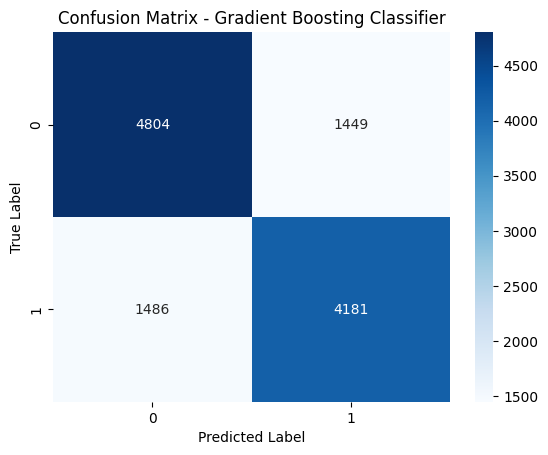


ROC-AUC Score: 0.8453

Gradient Boosting Feature Importance:
Feature 0: 0.0046
Feature 1: 0.0176
Feature 2: 0.0010
Feature 3: 0.0457
Feature 4: 0.0310
Feature 5: 0.0344
Feature 6: 0.0001
Feature 7: 0.0158
Feature 8: 0.0105
Feature 9: 0.0000
Feature 10: 0.0000
Feature 11: 0.0000
Feature 12: 0.0000
Feature 13: 0.0000
Feature 14: 0.0168
Feature 15: 0.0405
Feature 16: 0.0157
Feature 17: 0.0331
Feature 18: 0.0008
Feature 19: 0.0081
Feature 20: 0.0000
Feature 21: 0.0037
Feature 22: 0.0002
Feature 23: 0.0000
Feature 24: 0.0018
Feature 25: 0.0034
Feature 26: 0.0038
Feature 27: 0.0045
Feature 28: 0.0000
Feature 29: 0.0000
Feature 30: 0.0001
Feature 31: 0.0000
Feature 32: 0.0312
Feature 33: 0.0080
Feature 34: 0.2134
Feature 35: 0.0000
Feature 36: 0.1277
Feature 37: 0.0114
Feature 38: 0.1363
Feature 39: 0.0000
Feature 40: 0.0012
Feature 41: 0.0000
Feature 42: 0.0848
Feature 43: 0.0595
Feature 44: 0.0000
Feature 45: 0.0000
Feature 46: 0.0000
Feature 47: 0.0000
Feature 48: 0.0139
Feature 49: 0.014

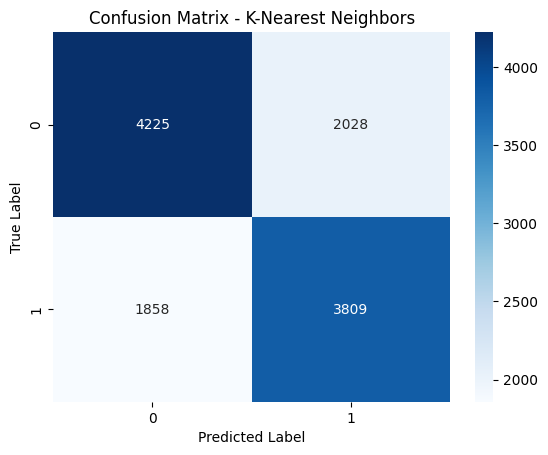


ROC-AUC Score: 0.7255


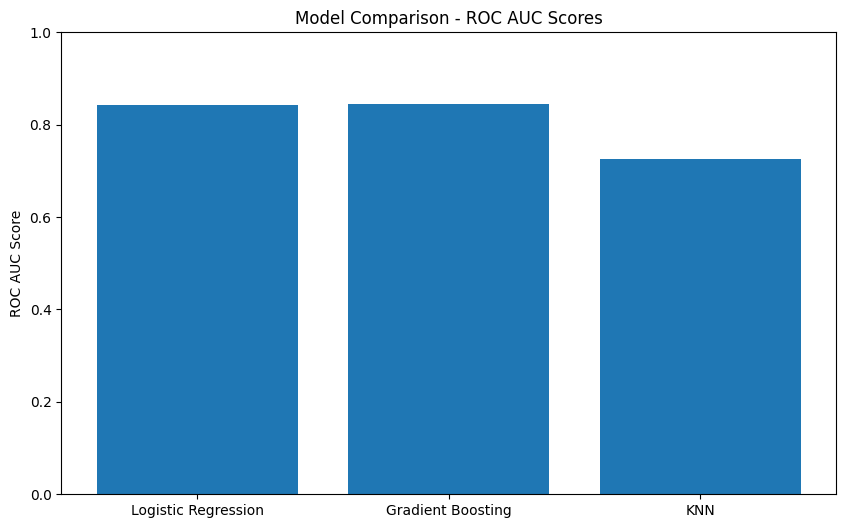


Model Comparison Summary:
Logistic Regression: ROC AUC = 0.8425
Gradient Boosting: ROC AUC = 0.8453
KNN: ROC AUC = 0.7255


In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data for both PySpark and Sklearn models
# Convert PySpark feature vector to numpy array for sklearn models
def convert_vector_to_array(row):
    return row.features.toArray()

# Get features and labels as numpy arrays
features_np = np.array(modeling_df.rdd.map(convert_vector_to_array).collect())
labels_np = np.array(modeling_df.select("label").collect()).flatten()

# 2. Split data
# For PySpark
spark_train, spark_test = modeling_df.randomSplit([0.8, 0.2], seed=42)

# For Sklearn
X_train, X_test, y_train, y_test = train_test_split(
    features_np, labels_np, test_size=0.2, random_state=42
)

# 3. Model Training and Evaluation Functions
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """
    Evaluate model performance with various metrics
    """
    print(f"\n{model_name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC-AUC Score
    auc_score = roc_auc_score(y_true, y_prob)
    print(f"\nROC-AUC Score: {auc_score:.4f}")

    return auc_score

# 4. Train and Evaluate Models

# A. Logistic Regression (PySpark)
print("\nTraining Logistic Regression (PySpark)...")
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(spark_train)

# Make predictions
lr_predictions = lr_model.transform(spark_test)

# Convert PySpark predictions to numpy for consistent evaluation
y_true_lr = lr_predictions.select("label").collect()
y_pred_lr = lr_predictions.select("prediction").collect()
y_prob_lr = lr_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()

# Evaluate Logistic Regression
lr_auc = evaluate_model(
    np.array(y_true_lr).flatten(),
    np.array(y_pred_lr).flatten(),
    np.array(y_prob_lr).flatten(),
    "Logistic Regression"
)

# Print feature importance for Logistic Regression
print("\nLogistic Regression Feature Importance:")
lr_weights = lr_model.coefficients.toArray()
for idx, weight in enumerate(lr_weights):
    print(f"Feature {idx}: {weight:.4f}")

# B. Gradient Boosting Classifier (Sklearn)
print("\nTraining Gradient Boosting Classifier...")
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

# Make predictions
y_pred_gbc = gbc.predict(X_test)
y_prob_gbc = gbc.predict_proba(X_test)[:, 1]

# Evaluate Gradient Boosting
gbc_auc = evaluate_model(y_test, y_pred_gbc, y_prob_gbc, "Gradient Boosting Classifier")

# Print feature importance for Gradient Boosting
print("\nGradient Boosting Feature Importance:")
for idx, importance in enumerate(gbc.feature_importances_):
    print(f"Feature {idx}: {importance:.4f}")

# C. K-Nearest Neighbors (Sklearn)
print("\nTraining KNN Classifier...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

# Evaluate KNN
knn_auc = evaluate_model(y_test, y_pred_knn, y_prob_knn, "K-Nearest Neighbors")

# 5. Compare Models
models_comparison = {
    'Logistic Regression': lr_auc,
    'Gradient Boosting': gbc_auc,
    'KNN': knn_auc
}

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.bar(models_comparison.keys(), models_comparison.values())
plt.title('Model Comparison - ROC AUC Scores')
plt.ylim(0, 1)
plt.ylabel('ROC AUC Score')
plt.show()

# Print final comparison
print("\nModel Comparison Summary:")
for model, auc in models_comparison.items():
    print(f"{model}: ROC AUC = {auc:.4f}")


Starting Hyperparameter Tuning...

Testing n_estimators...
Testing learning rates...
Testing max depths...

Testing KNN neighbors...

Training final models with best parameters...

Best Parameters Found:
Gradient Boosting:
- n_estimators: 200
- learning_rate: 0.1
- max_depth: 3
- Performance: Accuracy = 0.7552, AUC = 0.8474

KNN:
- n_neighbors: 7
- Performance: Accuracy = 0.6828, AUC = 0.7439


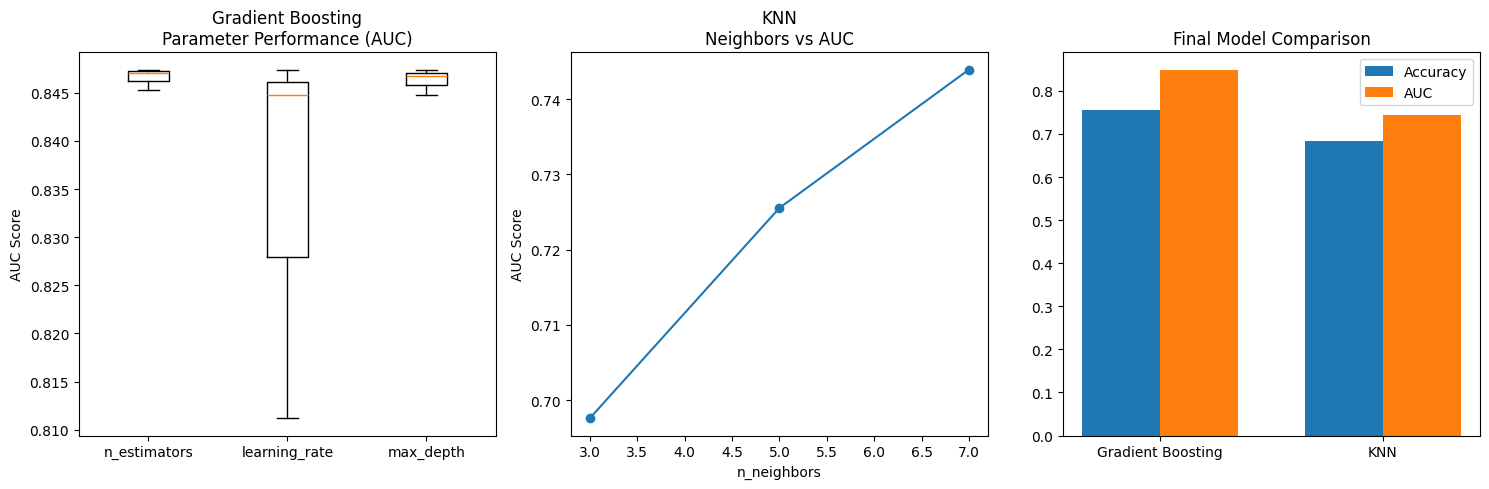

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob)

print("Starting Hyperparameter Tuning...")

# 1. Gradient Boosting Tuning

# Test n_estimators (keeping other parameters default)
n_estimators_list = [100, 200, 300]
n_estimators_scores = []

print("\nTesting n_estimators...")
for n_est in n_estimators_list:
    gb = GradientBoostingClassifier(n_estimators=n_est, random_state=42)
    acc, auc = evaluate_model(gb, X_train, y_train, X_test, y_test)
    n_estimators_scores.append({'n_estimators': n_est, 'accuracy': acc, 'auc': auc})

# Find best n_estimators
best_n_estimators = max(n_estimators_scores, key=lambda x: x['auc'])['n_estimators']

# Test learning_rates with best n_estimators
learning_rates = [0.01, 0.1, 0.3]
learning_rate_scores = []

print("Testing learning rates...")
for lr in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=best_n_estimators,
                                   learning_rate=lr,
                                   random_state=42)
    acc, auc = evaluate_model(gb, X_train, y_train, X_test, y_test)
    learning_rate_scores.append({'learning_rate': lr, 'accuracy': acc, 'auc': auc})

# Find best learning_rate
best_learning_rate = max(learning_rate_scores, key=lambda x: x['auc'])['learning_rate']

# Test max_depths with best n_estimators and learning_rate
max_depths = [3, 4, 5]
max_depth_scores = []

print("Testing max depths...")
for depth in max_depths:
    gb = GradientBoostingClassifier(n_estimators=best_n_estimators,
                                   learning_rate=best_learning_rate,
                                   max_depth=depth,
                                   random_state=42)
    acc, auc = evaluate_model(gb, X_train, y_train, X_test, y_test)
    max_depth_scores.append({'max_depth': depth, 'accuracy': acc, 'auc': auc})

# Find best max_depth
best_max_depth = max(max_depth_scores, key=lambda x: x['auc'])['max_depth']

# 2. KNN Tuning
print("\nTesting KNN neighbors...")
n_neighbors_list = [3, 5, 7]
knn_scores = []

for n in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n)
    acc, auc = evaluate_model(knn, X_train, y_train, X_test, y_test)
    knn_scores.append({'n_neighbors': n, 'accuracy': acc, 'auc': auc})

# Find best n_neighbors
best_n_neighbors = max(knn_scores, key=lambda x: x['auc'])['n_neighbors']

# 3. Final Model Comparison
print("\nTraining final models with best parameters...")

# Best Gradient Boosting Model
best_gb = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    random_state=42
)

# Best KNN Model
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)

# Evaluate final models
gb_acc, gb_auc = evaluate_model(best_gb, X_train, y_train, X_test, y_test)
knn_acc, knn_auc = evaluate_model(best_knn, X_train, y_train, X_test, y_test)

# Print results
print("\nBest Parameters Found:")
print(f"Gradient Boosting:")
print(f"- n_estimators: {best_n_estimators}")
print(f"- learning_rate: {best_learning_rate}")
print(f"- max_depth: {best_max_depth}")
print(f"- Performance: Accuracy = {gb_acc:.4f}, AUC = {gb_auc:.4f}")

print(f"\nKNN:")
print(f"- n_neighbors: {best_n_neighbors}")
print(f"- Performance: Accuracy = {knn_acc:.4f}, AUC = {knn_auc:.4f}")

# Visualize results
plt.figure(figsize=(15, 5))

# Plot 1: Gradient Boosting Parameters
plt.subplot(131)
gb_params_auc = [
    [score['auc'] for score in n_estimators_scores],
    [score['auc'] for score in learning_rate_scores],
    [score['auc'] for score in max_depth_scores]
]
plt.boxplot(gb_params_auc, labels=['n_estimators', 'learning_rate', 'max_depth'])
plt.title('Gradient Boosting\nParameter Performance (AUC)')
plt.ylabel('AUC Score')

# Plot 2: KNN Parameters
plt.subplot(132)
plt.plot(n_neighbors_list, [score['auc'] for score in knn_scores], marker='o')
plt.title('KNN\nNeighbors vs AUC')
plt.xlabel('n_neighbors')
plt.ylabel('AUC Score')

# Plot 3: Final Model Comparison
plt.subplot(133)
models = ['Gradient Boosting', 'KNN']
final_aucs = [gb_auc, knn_auc]
final_accs = [gb_acc, knn_acc]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, final_accs, width, label='Accuracy')
plt.bar(x + width/2, final_aucs, width, label='AUC')
plt.xticks(x, models)
plt.title('Final Model Comparison')
plt.legend()

plt.tight_layout()
plt.show()